# 자전거 대여 데이터

- 2011년부터 2012년까지 2년간의 자전거 대여 데이터
- 캐피털 바이크셰어 회사가 공개한 운행 기록에 다양한 외부 소스에서 얻은 당시 날씨 정보를 조합
- 한 시간 간격으로 기록됨
- 훈련 데이터 : 매달 1일부터 19일 까지의 기록
- 테스트 데이터 : 매달 20일부터 월말까지의 기록
- 피처
    - datetime : 기록 일시(1시간 간격)
    - season : 계절
        - 1 : 봄(1분기)
        - 2 : 여름(2분기)
        - 3 : 가을(3분기)
        - 4 : 겨울(4분기)
        - 공식 문서에는 계절로 설명하고 있지만 실제로는 분기로 나누어져 있음
    - holiday : 공휴일 여부(0 : 공휴일 아님, 1: 공휴일)
    - workingday : 근무일 여부(0 : 근무일 아님, 1 : 근무일)
        - 주말과 공휴일이 아니면 근무일이라고 간주
    - weather : 날씨
        - 1 : 맑음
        - 2 : 옅은 안개, 약간 흐림
        - 3 : 약간의 눈, 약간의 비와 천둥 번개, 흐림
        - 4 : 폭우와 천둥 번개, 눈과 짙은 안개
        - 숫자가 클수록 날씨가 안 좋음
    - temp : 실제 온도
    - atemp : 체감온도
    - humidity : 상대 습도
    - windspeed : 풍속
    - casual : 등록되지 않은 사용자(비회원) 수
    - registered : 등록된 사용자(회원) 수
    - count : 자전거 대여 수량
- 종속변수 : count
- 평가지표 : RMSLE(Root Mean Squared Logarithmic Error), 0.37

In [1]:
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

In [2]:
def rmsle(y_true, y_pred, convertExp = True):
    '''
    실제 타깃값과 예측값을 인수로 전달하면 RMSLE 수치를 반환하는 함수
    convertExp : 입력 데이터를 지수변환할지 정하는 파라미터
    타깃값으로 log(count)를 사용한 경우에는 지수변환을 해줘야 함
    '''
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))

    return output

- RMSLE 는 예측값과 실제값 사이의 상대적인 오차를 측정
- 즉, 예측값과 실제값 사이의 비율을 중요시
    - 이는 큰 값에 대한 예측이 작은 값에 대한 예측보다 더 많은 오차를 가지더라도, 그 차이가 상대적으로 작다면 RMSLE 값이 크게 증가하지 않음
    - 따라서 예측값과 실제값의 비율이 중요한 상황에서 RMSLE 를 사용
- RMSLE는 오차가 크게 발생했을 때 그에 대해 더 관대한 경향이 있음
- 예측값이 실제값보다 매우 크거나 작은 경우에도 오차의 절대적인 크기가 아닌 상대적인 크기를 고려하기 때문에, 모델의 성능을 과대평가할 위험이 있음

In [3]:
SEED = 12

# 데이터 확인

In [4]:
train_df = pd.read_csv("./data/bike/train.csv")
test_df = pd.read_csv("./data/bike/test.csv")
submission_df = pd.read_csv("./data/bike/sampleSubmission.csv")

In [5]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
submission_df.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [8]:
train_df.shape, test_df.shape, submission_df.shape

((10886, 12), (6493, 9), (6493, 2))

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 결측값 없음
- datetime 은 날짜인데 object로 표현되어 전처리가 필요함
    - 날짜, 연도, 월, 일, 시, 분, 초 로 각각 컬럼 생성

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


train_df.describe()

# 데이터 분석

## datatime 구성요소별로 나누기

In [11]:
train_df["datetime"][0]

'2011-01-01 00:00:00'

In [12]:
train_df["datetime"][0].split()

['2011-01-01', '00:00:00']

In [13]:
train_df["datetime"][0].split()[1].split(":")

['00', '00', '00']

In [14]:
train_df["datetime"].str.split().get(0)

['2011-01-01', '00:00:00']

In [15]:
train_df["date"] = train_df["datetime"].map(lambda x: x.split()[0])
train_df["year"] = train_df["datetime"].map(lambda x: x.split()[0].split("-")[0])
train_df["month"] = train_df["datetime"].map(lambda x: x.split()[0].split("-")[1])
train_df["day"] = train_df["datetime"].map(lambda x: x.split()[0].split("-")[2])
train_df["hour"] = train_df["datetime"].map(lambda x: x.split()[1].split(":")[0])
train_df["minute"] = train_df["datetime"].map(lambda x: x.split()[1].split(":")[1])
train_df["second"] = train_df["datetime"].map(lambda x: x.split()[1].split(":")[2])

In [16]:
calendar.day_name[0]

'Monday'

In [17]:
pd.to_datetime(train_df["date"])

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
10881   2012-12-19
10882   2012-12-19
10883   2012-12-19
10884   2012-12-19
10885   2012-12-19
Name: date, Length: 10886, dtype: datetime64[ns]

In [18]:
calendar.day_name[pd.to_datetime(train_df["date"])[0].weekday()]

'Saturday'

In [19]:
train_df["weekday"] = train_df["date"].map(lambda x: calendar.day_name[pd.to_datetime(x).weekday()])

In [20]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


## season, weather 범주형 데이터 문자열로 변환

In [21]:
train_df["season"] = train_df["season"].map({1 : "Spring",
                                            2 : "Summer",
                                            3 : "Fall",
                                            4 : "Winter"})
train_df["weather"] = train_df["weather"].map({1 : "Clear",
                                              2 : "Mist, Few clouds",
                                              3 : "Lingt Snow, Rain, Thunder",
                                              4 : "Heavy Snow, Rain, Thunder"})

In [22]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


## 정리

- date 컬럼의 정보는 year, month, day 에도 있어서 제거하는 편이 더 나을 수도 있음
- month 컬럼은 세 달씩 묶으면 season이 되기 때문에 연관성이 너무 높아서 제거하는 편이 더 나을 수 있음

# 데이터 시각화

## 종속변수 분포도

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


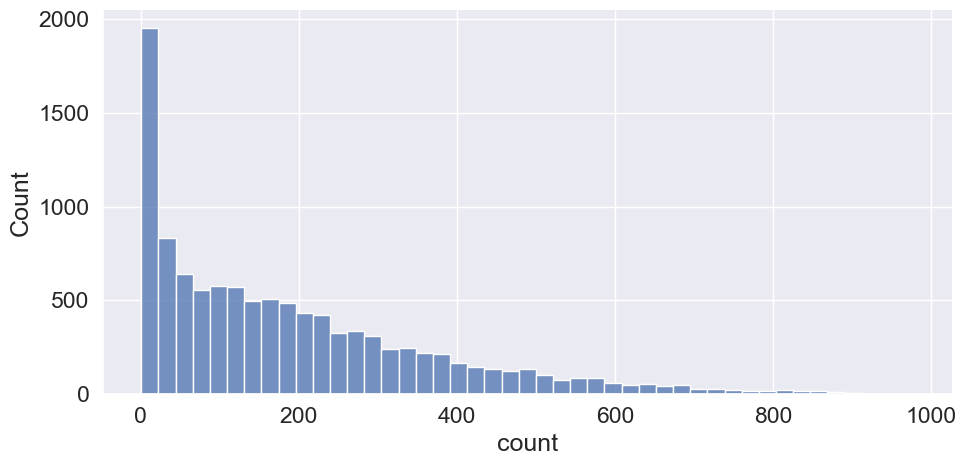

In [23]:
sns.set(font_scale = 1.5)
sns.displot(train_df["count"], height = 5, aspect = 2)
plt.show()

- 회귀 모델이 좋은 성능을 내기 위해서는 데이터가 정규분포를 따르는 것이 제일 좋은데 0근처에 몰려 있음

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


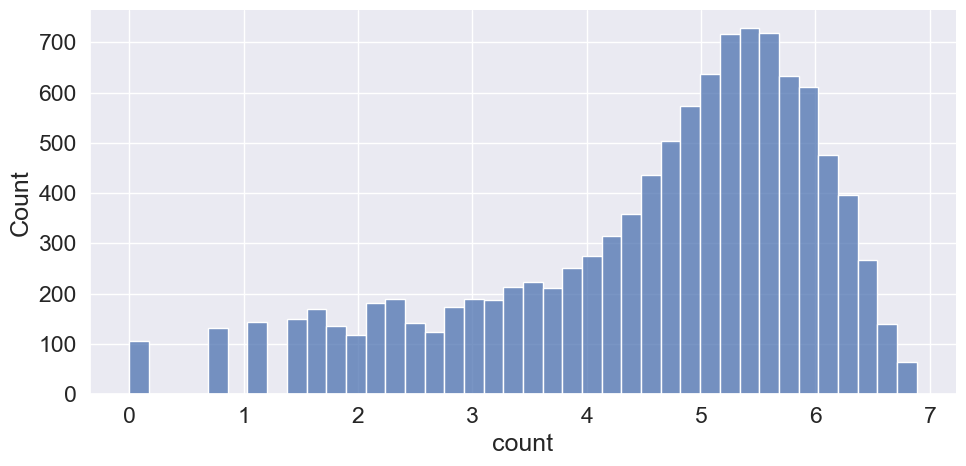

In [24]:
sns.displot(np.log(train_df["count"]), height = 5, aspect = 2)
plt.show()

- log 변환하면 큰 값은 더 많이 줄이고 작은 값은 조금만 줄여서 전체 범위가 줄어듦
- count 로 예측하는 것 보다 log(count)로 예측하는 것이 더 정확할 수 있음
    - log(count)로 예측하면 예측값에 지수변환하여 실제값이 count로 복원해야함

### 시간관련 컬럼과 종속변수 관계

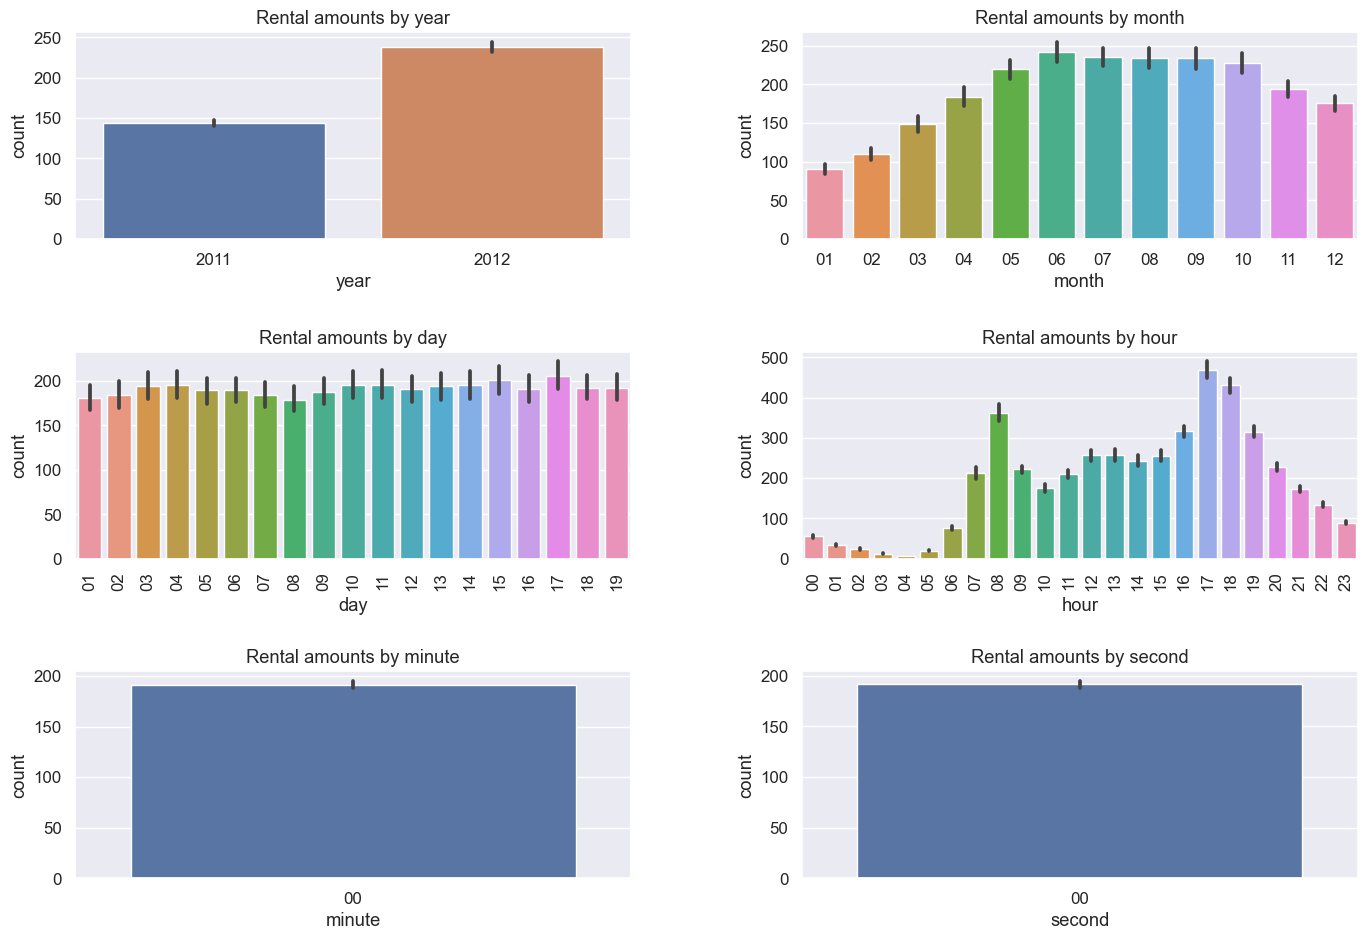

In [25]:
# 스텝 1 : m 행 n 열 Figure 준비
sns.set(font_scale = 1.1)
fig, axes = plt.subplots(nrows = 3, ncols = 2) # 3행 2열 Figure 생성
plt.tight_layout() # 그래프 사이 여백 확보
fig.set_size_inches(15, 10)

# 스텝 2 : 각 축에 서브플롯 할당
# 각 축에 연도, 월, 일, 시간, 분, 초 별 평균 대여 수량 막대 그래프 할당
sns.barplot(x = "year", y = "count", data = train_df, ax = axes[0, 0])
sns.barplot(x = "month", y = "count", data = train_df, ax = axes[0, 1])
sns.barplot(x = "day", y = "count", data = train_df, ax = axes[1, 0])
sns.barplot(x = "hour", y = "count", data = train_df, ax = axes[1, 1])
sns.barplot(x = "minute", y = "count", data = train_df, ax = axes[2, 0])
sns.barplot(x = "second", y = "count", data = train_df, ax = axes[2, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title = "Rental amounts by year")
axes[0, 1].set(title = "Rental amounts by month")
axes[1, 0].set(title = "Rental amounts by day")
axes[1, 1].set(title = "Rental amounts by hour")
axes[2, 0].set(title = "Rental amounts by minute")
axes[2, 1].set(title = "Rental amounts by second")

# 3-2 : 1행에 위치한 서브플롯들의 x축 레이블 90도 회전
axes[1, 0].tick_params(axis = "x", labelrotation = 90)
axes[1, 1].tick_params(axis = "x", labelrotation = 90)

plt.show()

- 2011년보다 2012년 대여량이 더 많음
- 6월에 가장 대여량이 많고 1월에 가장 적음
    - 날씨가 따뜻할수록 대여 수량이 많을 수 있음
- day는 일별 대여량에 큰 차이가 없고 훈련데이터와 테스트 데이터의 day 값이 다르기 때문에 제거해야함
- 새벽 4시에 가장 대여량이 적고 아침 8시와 저녁 5 ~ 6시 대여량이 가장 많음
- minute과 second 는 0 데이터만 존재
    - 아무 정보 없기 때문에 제거해야함

### 범주형 데이터 시각화

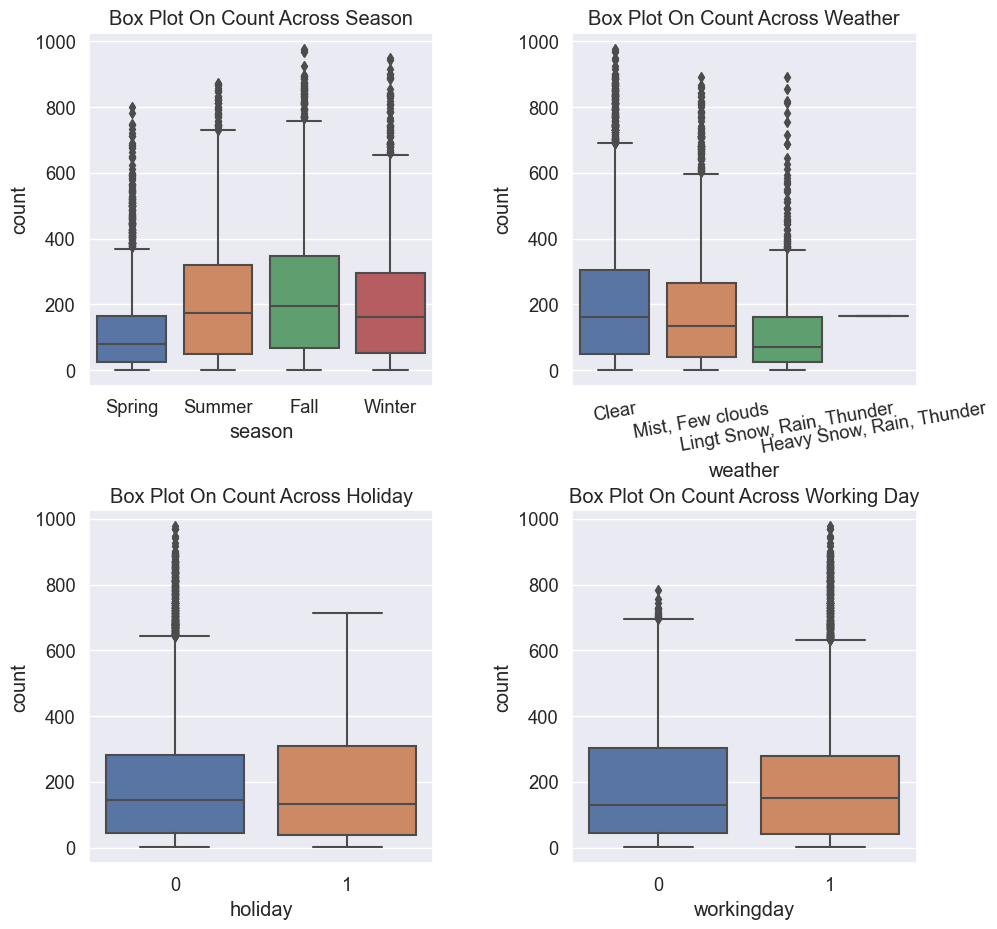

In [26]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(nrows = 2, ncols = 2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이 여백 확보
fig.set_size_inches(10, 10)

# 스텝 2 : 서브플롯 할당
# 계절, 날씨, 공휴일, 근무일 별 대여 수량 박스플롯
sns.boxplot(x = "season", y = "count", data = train_df, ax = axes[0, 0])
sns.boxplot(x = "weather", y = "count", data = train_df, ax = axes[0, 1])
sns.boxplot(x = "holiday", y = "count", data = train_df, ax = axes[1, 0])
sns.boxplot(x = "workingday", y = "count", data = train_df, ax = axes[1, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title = "Box Plot On Count Across Season")
axes[0, 1].set(title = "Box Plot On Count Across Weather")
axes[1, 0].set(title = "Box Plot On Count Across Holiday")
axes[1, 1].set(title = "Box Plot On Count Across Working Day")

# 3 - 2 : x축 레이블 겹침 해결
axes[0, 1].tick_params("x", labelrotation = 10) # 10도 회전

plt.show()

- 봄에 대여량이 가장 적고 가을에 가장 많음
- 날씨가 좋을 때 가장 대여량이 많고 날씨가 안좋아질수록 대여량이 적음
- 공휴일이 아닐 때와 공휴일일 때 대여량의 중앙값은 거의 비슷하지만 공휴일이 아닐 때에는 이상치가 많음
- 근무일로 봐도 마찬가지 근무일일 때 이상치가 많음

### 시간대별 평균 대여수량

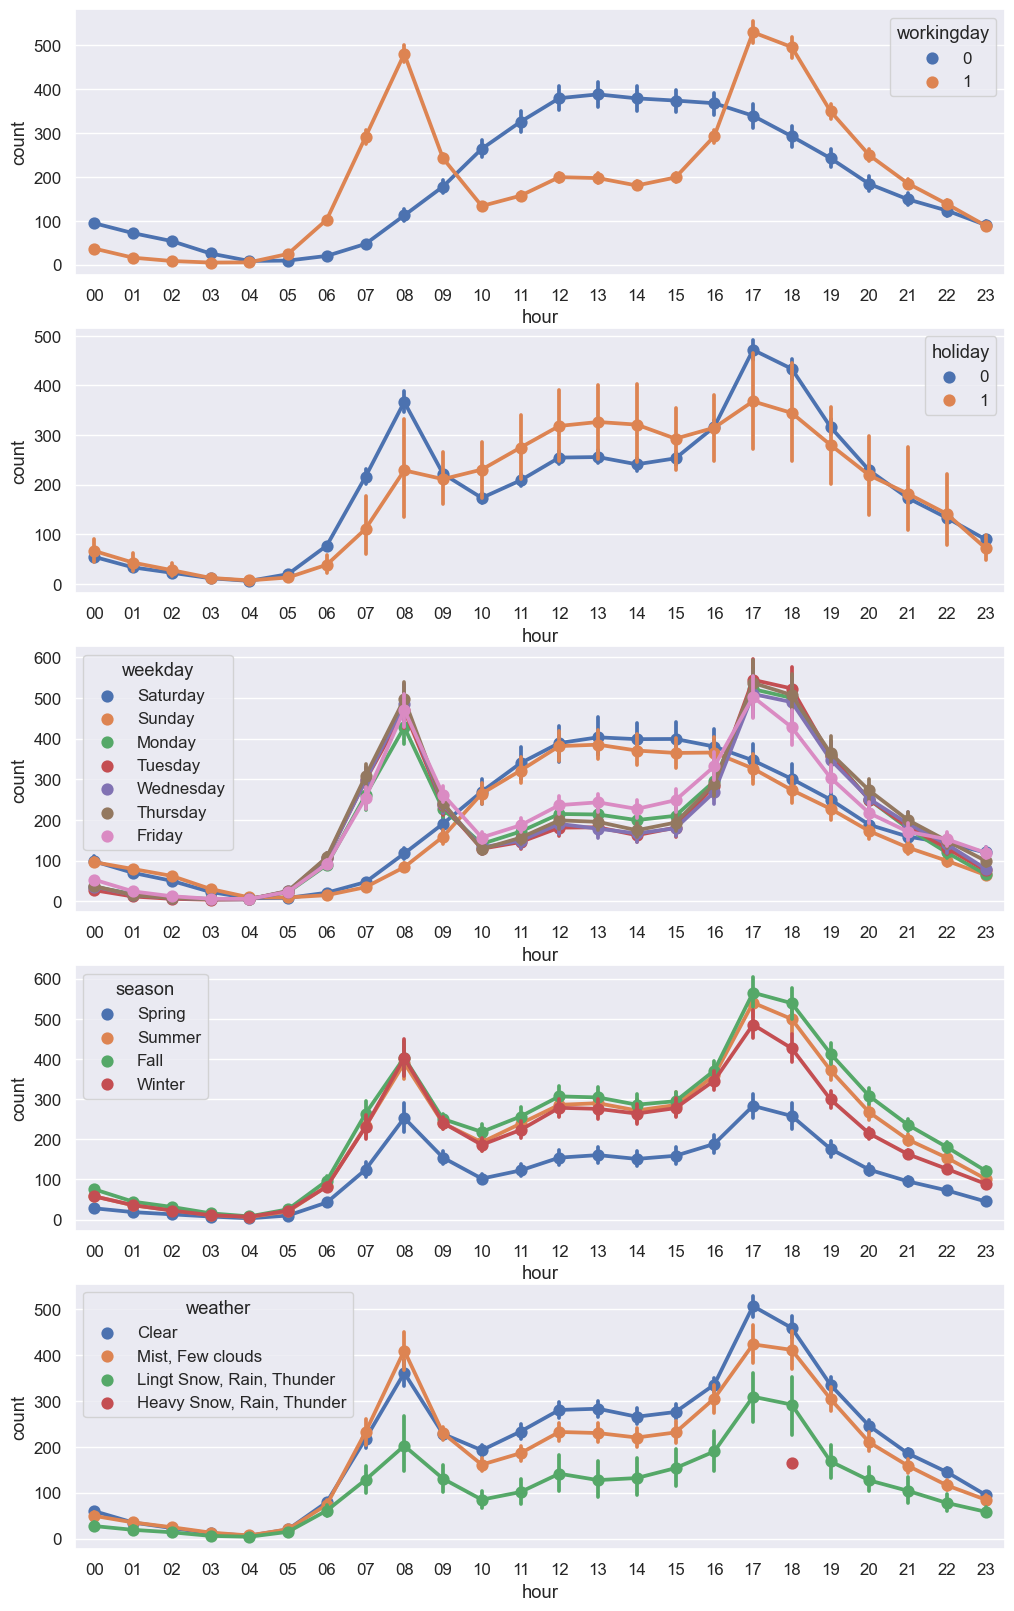

In [27]:
# 스텝 1 : m행 n열 Figure 준비
sns.set(font_scale = 1.1)
fig, axes = plt.subplots(nrows = 5) # 5행 1열
fig.set_size_inches(12, 20)

# 스텝 2 : 서브플롯 할당
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트플롯
sns.pointplot(x = "hour", y = "count", data = train_df, hue = "workingday", ax = axes[0])
sns.pointplot(x = "hour", y = "count", data = train_df, hue = "holiday", ax = axes[1])
sns.pointplot(x = "hour", y = "count", data = train_df, hue = "weekday", ax = axes[2])
sns.pointplot(x = "hour", y = "count", data = train_df, hue = "season", ax = axes[3])
sns.pointplot(x = "hour", y = "count", data = train_df, hue = "weather", ax = axes[4])

plt.show()

- 근무일에는 출퇴근 시간에 대여량이 많고 쉬는 날에는 오후 12 ~ 2시에 대여량이 많음
- 공휴일, 요일에 따른 그래프도 근무일 여부에 따른 그래프와 유사함
- 가을에 가장 대여량이 많고 봄에 가장 적음
- 날씨가 좋을 때 가장 대여량이 많음
    - 폭우, 폭설이 내릴 때 저녁 6시에 대여건수가 있음
        - 이상치로 처리하는 것이 더 좋을 수 있음

### 날씨 데이터 시각화

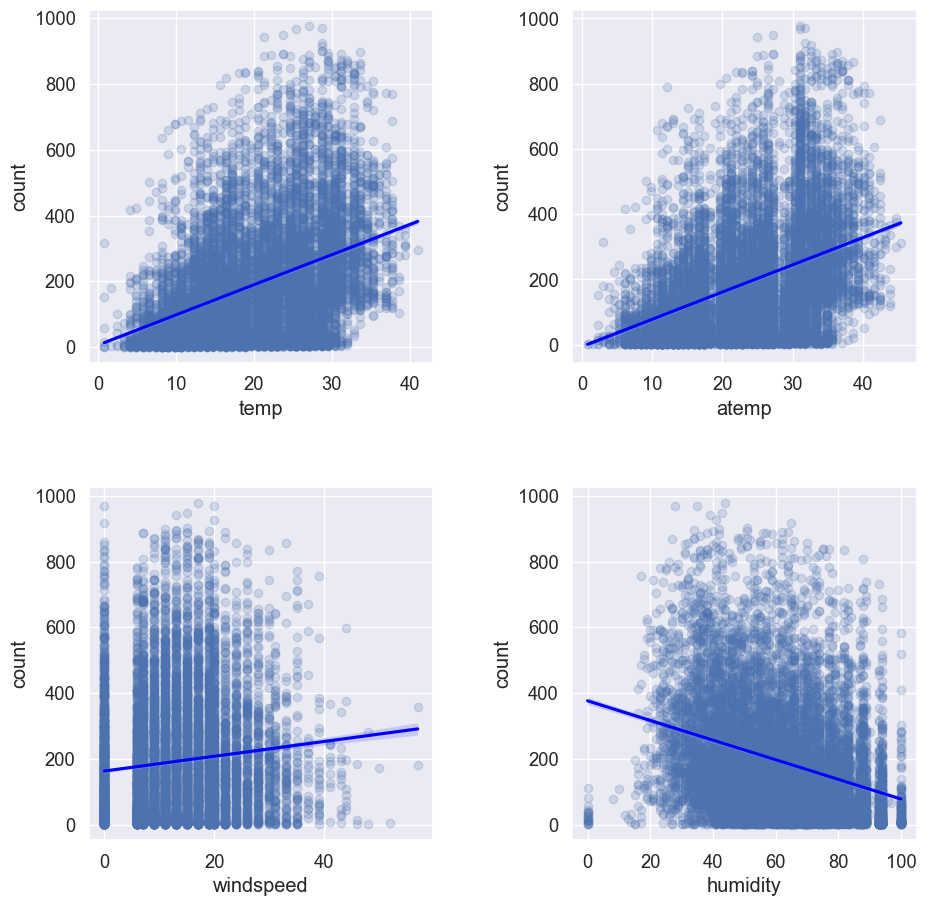

In [28]:
# 스텝 1 : m 행 n 열 Figure 준비
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(nrows = 2, ncols = 2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이 여백 확보
fig.set_size_inches(10, 10)

# 스텝 2 : 서브플롯 할당
# 온도, 체감온도, 풍속, 습도 별 대여 수량 산점도 그래프
sns.regplot(x = "temp", y = "count", data = train_df, ax = axes[0, 0], scatter_kws = {"alpha" : 0.2}, line_kws = {"color" : "blue"})
sns.regplot(x = "atemp", y = "count", data = train_df, ax = axes[0, 1], scatter_kws = {"alpha" : 0.2}, line_kws = {"color" : "blue"})
sns.regplot(x = "windspeed", y = "count", data = train_df, ax = axes[1, 0], scatter_kws = {"alpha" : 0.2}, line_kws = {"color" : "blue"})
sns.regplot(x = "humidity", y = "count", data = train_df, ax = axes[1, 1], scatter_kws = {"alpha" : 0.2}, line_kws = {"color" : "blue"})

plt.show()

- 실제 온도와 체감 온도가 높을수록 대여량이 많음
- 습도가 낮을수록 대여량이 많음
- 풍속은 셀수록 대여량이 많음
    - 풍속이 0인 데이터가 많고 풍속이 비어있는 구간이 있어 관측 오류가 의심됨
        - 이상값 대체를 하거나 컬럼 삭제를 고려해야함

### 히트맵

In [29]:
# 수치형 컬럼만 선택
corr_mat = train_df[["temp", "atemp", "humidity", "windspeed", "count"]].corr()
corr_mat

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


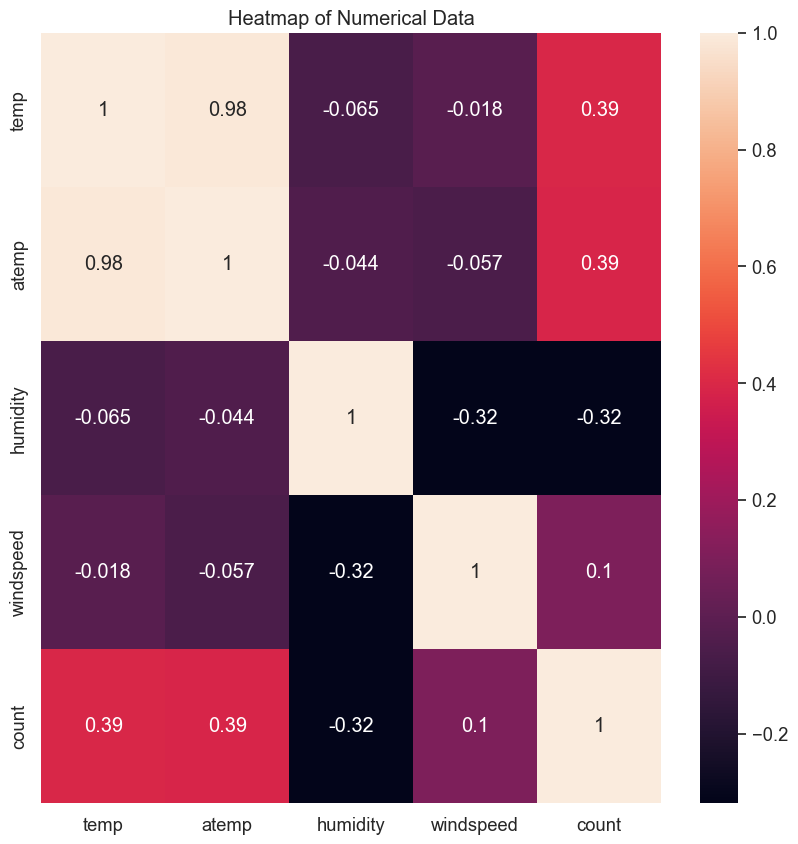

In [30]:
# 피처 간 상관관계 행렬
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

sns.heatmap(corr_mat, annot = True) # 상관관계 히트맵 그리기

ax.set(title = "Heatmap of Numerical Data")
plt.show()

- 풍속은 상관관계가 매우 약해서 모델 학습에 악영향을 줄 수 있음

## 정리

- 종속변수를 로그변환하여 정규분포에 가깝게 변환한 후 모델 학습
- datetime 컬럼은 여러 정보의 혼합체이기 때문에 각각 연도, 월, 일, 시간, 분, 초, 요일 컬럼으로 분리
    - datetime 은 인덱스 역할만 하기 때문에 삭제
    
- 테스트 데이터에 없는 casual 과 registered는 삭제

- date 컬럼이 제공하는 정보는 모두 year, month, day 로 분리했기 때문에 삭제

- month 는 season의 세부 분류로 볼 수 있음
    - 데이터가 지나치게 세분화되면 분류별 데이터 수가 적어져 오히려 학습에 방해가 될 수 있어서 제거
    
- day는 분별력이 없어서 제거

- minute과 second 는 아무런 정보가 없어서 제거

- weather가 4인 경우는 이상치 처리

- windspeed 컬럼은 결측값이 많고 대여량과의 관계가 매우 약해서 제거

## 모델링 전략

- 베이스라인 모델 : 가장 기본적인 선형회귀 모델
- 타깃값은 log(count) 사용

#  데이터 전처리

In [31]:
train_df = pd.read_csv("./data/bike/train.csv")
test_df = pd.read_csv("./data/bike/test.csv")
submission_df = pd.read_csv("./data/bike/sampleSubmission.csv")

In [32]:
# 날씨 이상치 제거
train_df = train_df[train_df["weather"] != 4]

In [33]:
# train 데이터와 test 데이터를 합쳐서 전처리 후 종속변수가 null 인 데이터와 아닌 데이터로 나누면 다시 train과 test로 나눠짐
all_df = pd.concat([train_df, test_df], ignore_index = True)
all_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [34]:
all_df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN
17377,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN


In [35]:
all_df["date"] = all_df["datetime"].map(lambda x: x.split()[0])
all_df["year"] = all_df["datetime"].map(lambda x: x.split()[0].split("-")[0])
all_df["month"] = all_df["datetime"].map(lambda x: x.split()[0].split("-")[1])
all_df["hour"] = all_df["datetime"].map(lambda x: x.split()[1].split(":")[0])
all_df["weekday"] = all_df["date"].map(lambda x: pd.to_datetime(x).weekday())

In [36]:
all_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,2011,01,00,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,2011,01,01,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2011,01,02,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,2011,01,03,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,2011,01,04,5


### 변수 제거

In [37]:
drop_features = ["casual", "registered", "datetime", "date", "month", "windspeed"]
all_df = all_df.drop(drop_features, axis = 1)

In [38]:
all_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,00,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,01,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,02,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,03,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,04,5


### 데이터 분할

In [39]:
train = all_df[~pd.isna(all_df["count"])]
test = all_df[pd.isna(all_df["count"])]

In [40]:
x_train = train.drop("count", axis = 1)
x_test = test.drop("count", axis = 1)
y = train["count"]

In [41]:
x_train.shape, x_test.shape, y.shape

((10885, 10), (6493, 10), (10885,))

In [42]:
x_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


In [43]:
x_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
10885,1,0,1,1,10.66,11.365,56,2011,00,3
10886,1,0,1,1,10.66,13.635,56,2011,01,3
10887,1,0,1,1,10.66,13.635,56,2011,02,3
10888,1,0,1,1,10.66,12.880,56,2011,03,3
10889,1,0,1,1,10.66,12.880,56,2011,04,3


# 베이스라인 모델

In [44]:
lr_l = LinearRegression()
log_y = np.log(y)
lr_l.fit(x_train, log_y)

LinearRegression()

In [45]:
lr_n = LinearRegression()
lr_n.fit(x_train, y)

LinearRegression()

In [46]:
pred_l = lr_l.predict(x_train)
pred_n = lr_n.predict(x_train)

In [47]:
print(rmsle(log_y, pred_l, True))
print(rmsle(y, pred_n, False))

1.0204980189305026
1.2936714652321732


C:\Users\sungj\AppData\Local\Temp\ipykernel_15780\2771910247.py:14: RuntimeWarning: invalid value encountered in log
  log_pred = np.nan_to_num(np.log(y_pred + 1))


- log(count)로 예측한 모델이 더 성능이 좋은 것을 확인

In [48]:
pred = lr_l.predict(x_test)
pred = np.exp(pred)
submission_df["count"] = pred
submission_df.to_csv("submission_baseline_test.csv", index = False)

In [49]:
submission_df

,datetime,count
0,2011-01-20 00:00:00,11.362398
1,2011-01-20 01:00:00,13.601789
2,2011-01-20 02:00:00,15.084417
3,2011-01-20 03:00:00,16.308758
4,2011-01-20 04:00:00,18.086453
...,...,...
6488,2012-12-31 19:00:00,114.076538
6489,2012-12-31 20:00:00,126.511160
6490,2012-12-31 21:00:00,140.114463
6491,2012-12-31 22:00:00,169.345347


#릿지

In [50]:
rid = Ridge(random_state = SEED)

In [51]:
# 하이퍼파라미터 값 목록
ridge_params = {"alpha" : [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 폄가 함수(RMSLE 점수 계산)
rmsle_scorer = make_scorer(rmsle, greater_is_better = False)

splitter = KFold(n_splits = 5, shuffle = True, random_state = SEED)

# 그리드 서치(with 릿지) 객체 생성
gs_rid = GridSearchCV(estimator = rid, # 릿지 모델
                      param_grid = ridge_params, # 값 목록
                      scoring = rmsle_scorer, # 평가지표
                      cv = splitter) # 교차검증 분할

In [52]:
gs_rid.fit(x_train, log_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=12, shuffle=True),
             estimator=Ridge(random_state=12),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [53]:
gs_rid.best_params_

{'alpha': 100}

In [54]:
gs_rid.best_score_

-1.021585547435922

In [55]:
preds = gs_rid.best_estimator_.predict(x_train)

In [56]:
rmsle(log_y, preds, True)

1.0204926733804116

In [57]:
pred = gs_rid.best_estimator_.predict(x_test)
pred = np.exp(pred)
submission_df["count"] = pred
submission_df.to_csv("submission_ridge_test.csv", index = False)

# 라쏘

In [58]:
las = Lasso(random_state = SEED)

In [59]:
# 하이퍼 파라미터 값 목록
lasso_alpha = 1 / np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {"max_iter" : [3000], "alpha" : lasso_alpha}

splitter = KFold(n_splits = 5, shuffle = True, random_state = SEED)

# 그리드 서치(with 라쏘) 객체 생성
gs_las = GridSearchCV(estimator = las,
                     param_grid = lasso_params,
                     scoring = rmsle_scorer,
                     cv = splitter)

In [60]:
gs_las.fit(x_train, log_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=12, shuffle=True),
             estimator=Lasso(random_state=12),
             param_grid={'alpha': array([1.00000000e+01, 1.00000000e+00, 5.00000000e-01, 3.33333333e-01,
       2.50000000e-01, 1.00000000e-01, 3.33333333e-02, 1.00000000e-02,
       5.00000000e-03, 3.33333333e-03, 2.50000000e-03, 1.25000000e-03,
       1.11111111e-03, 1.00000000e-03]),
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [61]:
gs_las.best_params_

{'alpha': 0.005, 'max_iter': 3000}

In [62]:
gs_las.best_score_

-1.0213651494566558

In [63]:
preds = gs_las.best_estimator_.predict(x_train)
rmsle(log_y, preds, True)

1.020474447521432

# 랜덤포레스트

In [64]:
rf = RandomForestRegressor(random_state = SEED)

In [65]:
# 그리드 서치 객체 생성
rf_params = {"n_estimators" : [100, 120, 140, 160]}

splitter = KFold(n_splits = 5, shuffle = True, random_state = SEED)

gs_rf = GridSearchCV(estimator = rf,
                    param_grid = rf_params,
                    scoring = rmsle_scorer,
                    cv = splitter)

In [66]:
gs_rf.fit(x_train, log_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=12, shuffle=True),
             estimator=RandomForestRegressor(random_state=12),
             param_grid={'n_estimators': [100, 120, 140, 160]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [67]:
gs_rf.best_params_

{'n_estimators': 160}

In [68]:
gs_rf.best_score_

-0.31140346283080556

In [69]:
preds = gs_rf.best_estimator_.predict(x_train)
rmsle(log_y, preds, True)

0.11243831427092683

In [70]:
pred = gs_rf.best_estimator_.predict(x_test)
pred = np.exp(pred)
submission_df["count"] = pred
submission_df.to_csv("submission_rf_test.csv", index = False)

# 추가 전처리

In [71]:
x_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


In [72]:
gs_rf.best_estimator_.feature_importances_

array([0.0360211 , 0.00160759, 0.03890995, 0.01188119, 0.04971593,
       0.01967922, 0.02308132, 0.03151683, 0.75643869, 0.03114817])

In [73]:
x_train.shape, train.shape

((10885, 10), (10885, 11))

In [74]:
x_test.shape, test.shape

((6493, 10), (6493, 11))

In [75]:
all_df = pd.concat([train, test], ignore_index = True)
all_df

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,00,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,01,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,02,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,03,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,04,5
...,...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,NaN,2012,19,0
17374,1,0,1,2,10.66,12.880,60,NaN,2012,20,0
17375,1,0,1,1,10.66,12.880,60,NaN,2012,21,0
17376,1,0,1,1,10.66,13.635,56,NaN,2012,22,0


In [80]:
# 계절, 공휴일 등 범주형 데이터를 원핫인코딩
all_ohe = pd.get_dummies(all_df, columns = ["season", "holiday", "workingday", "weather", "year", "hour", "weekday"])

In [81]:
all_ohe.head()

,temp,atemp,humidity,count,season_1,season_2,season_3,season_4,holiday_0,holiday_1,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,9.84,14.395,81,16.0,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,9.02,13.635,80,40.0,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,9.02,13.635,80,32.0,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,9.84,14.395,75,13.0,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
4,9.84,14.395,75,1.0,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False


In [82]:
train_ohe = all_ohe[~pd.isna(all_df["count"])]
test_ohe = all_ohe[pd.isna(all_df["count"])]

In [83]:
x_train_ohe = train_ohe.drop("count", axis = 1)
x_test_ohe = test_ohe.drop("count", axis = 1)

# 선형회귀 + 원핫인코딩

In [84]:
lr_ohe = LinearRegression()
lr_ohe.fit(x_train_ohe, log_y)

LinearRegression()

In [85]:
preds = lr_ohe.predict(x_train_ohe)
rmsle(log_y, preds, True)

0.5829611969218325

# 릿지 + 원핫인코딩

In [86]:
rid = Ridge(random_state = SEED)

In [87]:
gs_Rid = GridSearchCV(estimator = rid,
                     param_grid = ridge_params,
                     scoring = rmsle_scorer,
                     cv = splitter)

In [89]:
gs_rid.fit(x_train_ohe, log_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=12, shuffle=True),
             estimator=Ridge(random_state=12),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [90]:
gs_rid.best_score_

-0.5850500472306728

In [91]:
preds = gs_rid.predict(x_train_ohe)
rmsle(log_y, preds, True)

0.5828671150529009

# 라쏘 + 원핫인코딩

In [92]:
las = Lasso(random_state = SEED)

In [93]:
gs_las = GridSearchCV(estimator = las,
                     param_grid = lasso_params,
                     scoring = rmsle_scorer,
                     cv = splitter)

In [94]:
gs_las.fit(x_train_ohe, log_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=12, shuffle=True),
             estimator=Lasso(random_state=12),
             param_grid={'alpha': array([1.00000000e+01, 1.00000000e+00, 5.00000000e-01, 3.33333333e-01,
       2.50000000e-01, 1.00000000e-01, 3.33333333e-02, 1.00000000e-02,
       5.00000000e-03, 3.33333333e-03, 2.50000000e-03, 1.25000000e-03,
       1.11111111e-03, 1.00000000e-03]),
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [95]:
gs_las.best_score_

-0.585415283101588

In [96]:
preds = gs_las.predict(x_train_ohe)
rmsle(log_y, preds, True)

0.5832930874262834

# 랜덤포레스트 + 원핫인코딩

In [97]:
rf = RandomForestRegressor(random_state = SEED)

In [98]:
gs_rf = GridSearchCV(estimator = rf,
                    param_grid = rf_params,
                    scoring = rmsle_scorer,
                     cv = splitter)

In [99]:
gs_rf.fit(x_train_ohe, log_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=12, shuffle=True),
             estimator=RandomForestRegressor(random_state=12),
             param_grid={'n_estimators': [100, 120, 140, 160]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [100]:
gs_rf.best_score_

-0.33322675951582215

In [101]:
preds = gs_rf.predict(x_train_ohe)
rmsle(log_y, preds, True)

0.12024498148570174